# Integración con **PySpark**
Otra alternativa para poder integrar todo este proyecto en conjunto y dentro todo mismo usando python puede ser con [PySpark](https://spark.apache.org/docs/latest/api/python/index.html). A continuación se detalla lo necesario para poder trabajar con esta librería y se analiza esta opción.

## Uso
Para iniciar a usar pyspark, es necesario primero crear una sesión de la siguiente forma (es necesario tener **Java** instalado:

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

24/07/09 19:58:22 WARN Utils: Your hostname, ideaparch resolves to a loopback address: 127.0.0.2, but we couldn't find any external IP address!
24/07/09 19:58:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/09 19:58:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/07/09 19:58:23 WARN MacAddressUtil: Failed to find a usable hardware address from the network interfaces; using random bytes: 55:7b:b1:39:bc:91:b6:e8


*Algunos *warnings* fueron arrojados, pero no parecen ser vitales.*

Pyspark trabaja de una manera más eficiente con `DataFrames` (usados también en Pandas) y estos pueden ser obtenidos a través de archivos que contengan fuentes de datos. En este caso, utilizarémos un ejemplo básico de un `geojson` (`JSON`).

### Leyendo `JSON` (`geojson`)
Una vez teniendo una sesión de PySpark es posible leer `JSON`s

In [2]:
geojson_df = spark.read.json("../assets/basic.json", multiLine=True)
geojson_df.show()

+--------------------+---------------+
|         coordinates|           type|
+--------------------+---------------+
|[[[1.0, 2.0]], [[...|MultiLineString|
+--------------------+---------------+



Casi de la misma forma que se leen los `JSON`s en `Python`. Es importante también considerar la bandera `multiLine`, ya que si no se establece esta, habrán errores de lectura.

In [3]:
# Leyendo json en Python
import json

with open('../assets/basic.json', 'r') as file:
    example_geojson = json.load(file)

example_geojson

{'type': 'MultiLineString', 'coordinates': [[[1.0, 2.0]], [[3.0, 4.0]]]}

### Cálculo de distancia euclideana
Teniendo el `JSON` (o `geojson`) cargado, se pueden definir funciones con las que PySpark podrá trabajar, denomidas [UDF (User Defined Functions)](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.functions.udf.html), para así poder definir una función que calcule la distancia euclideana de las coordenadas que nuestro `JSON` contenga.

In [4]:
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
from math import sqrt

# Define UDF to calculate Euclidean distance
def euclidean_distance(coords):
    point1 = coords[0][0]
    point2 = coords[1][0]
    return float(sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2))

distance_udf = F.udf(euclidean_distance, FloatType())

geojson_df = geojson_df.withColumn('distance', distance_udf(F.col('coordinates')))
geojson_df.show(truncate=False)

+----------------------------+---------------+--------+
|coordinates                 |type           |distance|
+----------------------------+---------------+--------+
|[[[1.0, 2.0]], [[3.0, 4.0]]]|MultiLineString|2.828427|
+----------------------------+---------------+--------+



In [5]:
import sys
import os.path

parent_dir = os.path.join(os.path.abspath(''), os.path.pardir)
sys.path.append(os.path.abspath(parent_dir))

from utils import plotfn
from src import euclidean

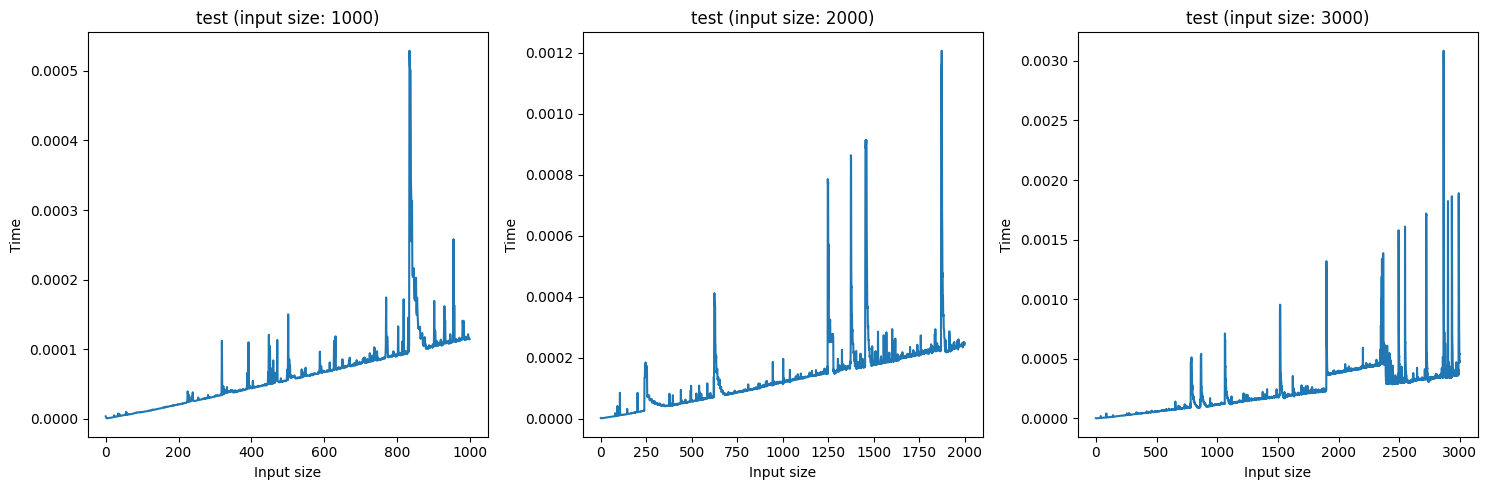

In [7]:
import random

def populate_lists(n: int) -> list[float]:
    arr = []

    for _ in range(n):
        arr.append(random.uniform(-99.0, -99.5))
        arr.append(random.uniform(19.3, 19.5))

    return arr

plotfn.time_complexity3(euclidean.distance, populate_lists, "test")